# Loading Data

In [ ]:
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

Dataset URL: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
License(s): other
 99% 1.20G/1.21G [00:13<00:00, 178MB/s]
100% 1.21G/1.21G [00:13<00:00, 96.0MB/s]


In [ ]:
!unzip /content/gtzan-dataset-music-genre-classification.zip

Archive:  /content/gtzan-dataset-music-genre-classification.zip
  inflating: Data/features_30_sec.csv  
  inflating: Data/features_3_sec.csv  
  inflating: Data/genres_original/blues/blues.00000.wav  
  inflating: Data/genres_original/blues/blues.00001.wav  
  inflating: Data/genres_original/blues/blues.00002.wav  
  inflating: Data/genres_original/blues/blues.00003.wav  
  inflating: Data/genres_original/blues/blues.00004.wav  
  inflating: Data/genres_original/blues/blues.00005.wav  
  inflating: Data/genres_original/blues/blues.00006.wav  
  inflating: Data/genres_original/blues/blues.00007.wav  
  inflating: Data/genres_original/blues/blues.00008.wav  
  inflating: Data/genres_original/blues/blues.00009.wav  
  inflating: Data/genres_original/blues/blues.00010.wav  
  inflating: Data/genres_original/blues/blues.00011.wav  
  inflating: Data/genres_original/blues/blues.00012.wav  
  inflating: Data/genres_original/blues/blues.00013.wav  
  inflating: Data/genres_original/blues/blues

In [ ]:
import pandas as pd
df=pd.read_csv("/content/Data/features_30_sec.csv")

# Assuming your DataFrame is named df
df = df[['filename', 'label']]
df['filename']="/content/Data/genres_original/"+df['label']+"/"+df['filename']

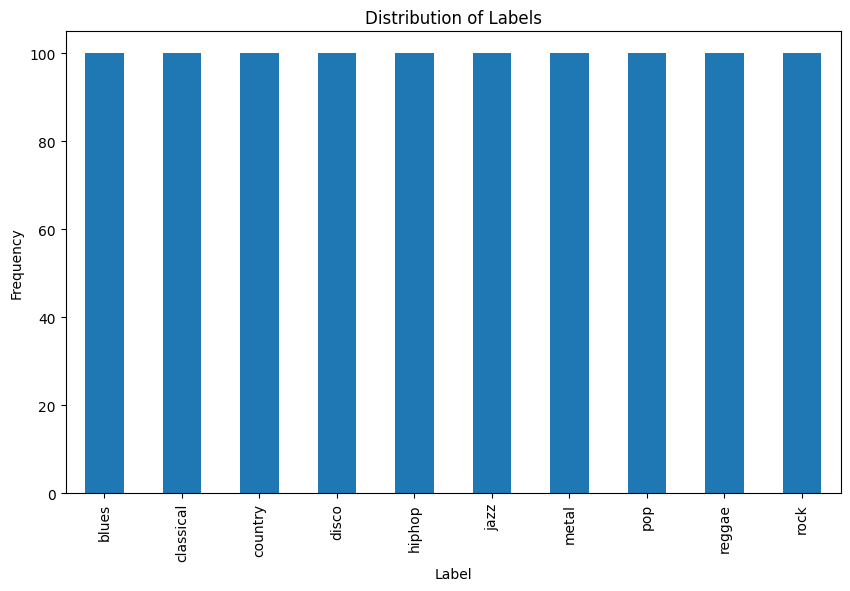

In [ ]:
import matplotlib.pyplot as plt
# Create histogram for 'label' column
plt.figure(figsize=(10, 6))
df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

# Feautre extraction

In [ ]:
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize


# Function to extract and save spectrogram
def extract_mfcc(audio_path, sr=16000, n_mfcc=13, frame_length_ms=25, frame_stride_ms=10):
    # Load the audio file
    audio, sampling_rate = librosa.load(audio_path, sr=sr)

    # Calculate frame length and frame stride in samples
    frame_length = int(frame_length_ms * sr / 1000)
    frame_stride = int(frame_stride_ms * sr / 1000)

    # Extract MFCC features
    mfccs = librosa.feature.mfcc(y=audio, sr=sampling_rate, n_mfcc=n_mfcc, n_fft=frame_length, hop_length=frame_stride)
    mfccs_processed = np.mean(mfccs.T, axis=0)  # take mean of MFCCs along the time axis

    return mfccs_processed


# Loop through the DataFrame and extract spectrograms
X=[]
Y=[]
for index, row in df.iterrows():
    file_path = row['filename']
    label = row['label']
    try:
      mfcc=extract_mfcc(file_path)
      X.append(mfcc)
      Y.append(label)
    except:
      print(f"{file_path} had problem")

<ipython-input-12-f22d45e79a24>:11: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(audio_path, sr=sr)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


/content/Data/genres_original/jazz/jazz.00054.wav had problem


In [ ]:
# Convert to numpy arrays
X = np.array(X)
Y = np.array(Y)


In [ ]:
import numpy as np

def train_test_split1(X, y, test_size=0.25, random_state=None):

    # Convert inputs to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Ensure consistent random state
    if random_state is not None:
        np.random.seed(random_state)

    # Shuffle the indices
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    # Determine the size of the test set
    if isinstance(test_size, float):
        test_size = int(test_size * X.shape[0])
    elif isinstance(test_size, int):
        test_size = test_size
    else:
        raise ValueError("test_size should be a float or an int")

    # Split the indices for training and testing
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]

    # Split the data
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    return X_train, X_test, y_train, y_test



In [ ]:

from sklearn.model_selection import train_test_split


# Split data into training and testing sets with an 80-20 split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 799
Testing set size: 200


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape).reshape(-1, 1, 13)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape).reshape(-1, 1, 13)



In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder


# Encode the genre labels as integers
label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(Y_train)
Y_test = label_encoder.transform(Y_test)


# LSTM 64

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# ساخت مدل
model = Sequential()


model.add(LSTM(64, input_shape=(1, 13), return_sequences=True))  # None برای تعداد فریم‌ها و 13 برای ویژگی‌های MFCC

# افزودن لایه LSTM دوم با 64 واحد
model.add(LSTM(64))

# افزودن لایه Dense با 64 نورون و تابع فعال‌ساز ReLU
model.add(Dense(64, activation='relu'))

# افزودن لایه Dropout با نرخ 0.3
model.add(Dropout(0.3))

# افزودن لایه Dense با 10 نورون خروجی و تابع فعال‌ساز Softmax
model.add(Dense(10, activation='softmax'))

# نمایش خلاصه‌ای از مدل
model.summary()

# کامپایل کردن مدل با بهینه‌ساز Adam و نرخ یادگیری 0.0001 و تابع زیان sparse_categorical_crossentropy
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


history=model.fit(X_train, Y_train, epochs=30, batch_size=32, validation_split=0.2 )


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 64)             19968     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 57802 (225.79 KB)
Trainable params: 57802 (225.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
20/20 [

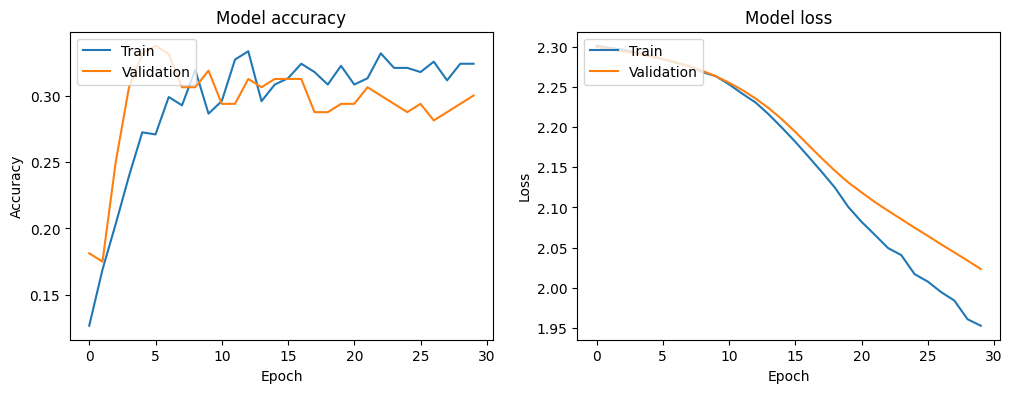

Test accuracy: 0.2600


In [ ]:
import matplotlib.pyplot as plt



# Plot the loss and accuracy
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f'Test accuracy: {test_accuracy:.4f}')


In [ ]:
loss,accuracy = model.evaluate(X_test,Y_test)
print(accuracy,loss)

7/7 [==============================] - 0s 4ms/step - loss: 2.0470 - accuracy: 0.2600
0.25999999046325684 2.047034978866577


7/7 [==============================] - 1s 4ms/step


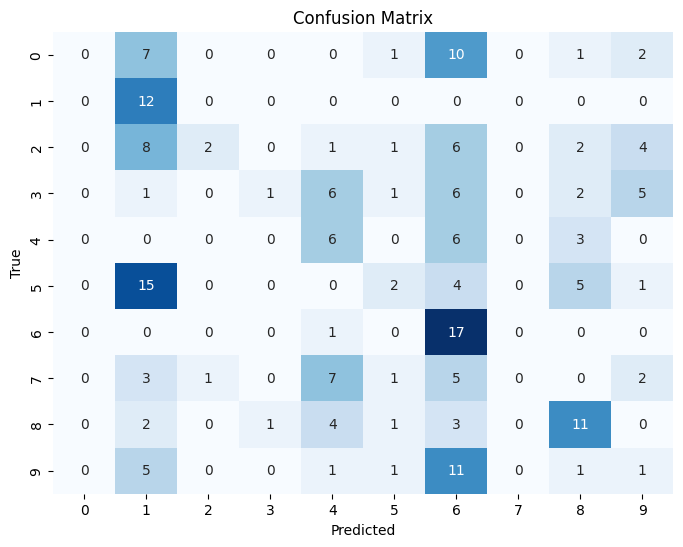

In [ ]:
# Predict the test set
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)


# Compute the confusion matrix
cm = confusion_matrix(Y_test, np.argmax(Y_pred,axis=1))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from sklearn.metrics import classification_report


# Generate classification report
report = classification_report(Y_test, np.argmax(Y_pred, axis=1))

print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.23      1.00      0.37        12
           2       0.67      0.08      0.15        24
           3       0.50      0.05      0.08        22
           4       0.23      0.40      0.29        15
           5       0.25      0.07      0.11        27
           6       0.25      0.94      0.40        18
           7       0.00      0.00      0.00        19
           8       0.44      0.50      0.47        22
           9       0.07      0.05      0.06        20

    accuracy                           0.26       200
   macro avg       0.26      0.31      0.19       200
weighted avg       0.28      0.26      0.18       200



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# LSTM 128

In [ ]:

from sklearn.model_selection import train_test_split


# Split data into training and testing sets with an 80-20 split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 799
Testing set size: 200


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape).reshape(-1, 1, 13)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape).reshape(-1, 1, 13)



In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder


# Encode the genre labels as integers
label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(Y_train)
Y_test = label_encoder.transform(Y_test)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Input
from tensorflow.keras.optimizers import Adam

# ساخت مدل
model = Sequential()

model.add(Input(shape = (1,13)))

model.add(LSTM(128))  # None برای تعداد فریم‌ها و 13 برای ویژگی‌های MFCC


# افزودن لایه Dense با 64 نورون و تابع فعال‌ساز ReLU
model.add(Dense(64, activation='relu'))

# افزودن لایه Dropout با نرخ 0.3
model.add(Dropout(0.3))

# افزودن لایه Dense با 10 نورون خروجی و تابع فعال‌ساز Softmax
model.add(Dense(10, activation='softmax'))

# نمایش خلاصه‌ای از مدل
model.summary()

# کامپایل کردن مدل با بهینه‌ساز Adam و نرخ یادگیری 0.0001 و تابع زیان sparse_categorical_crossentropy
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


history=model.fit(X_train, Y_train, epochs=30, batch_size=32, validation_split=0.2 )


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               72704     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 81610 (318.79 KB)
Trainable params: 81610 (318.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
20/20 [==============================] - 4s 36ms/step - loss: 2.3030 - accuracy: 0.1002 - val_loss: 2.2911 - val_accuracy: 0.1375
Epoch 2

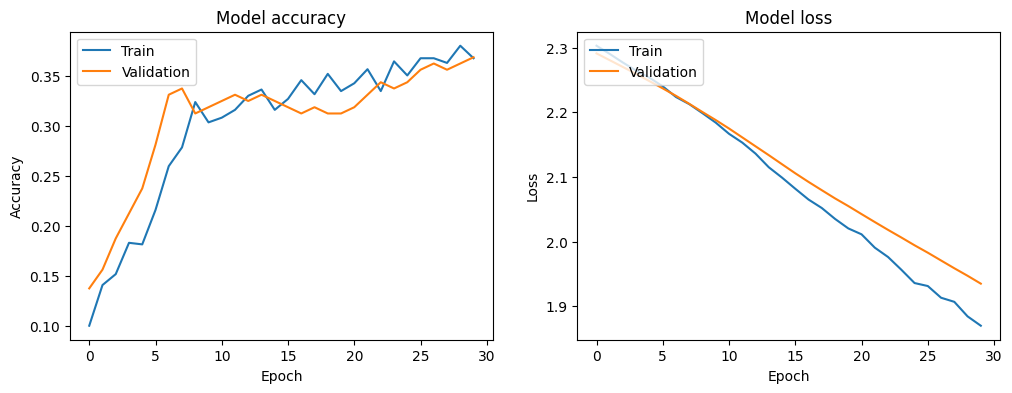

Test accuracy: 0.3150


In [ ]:
import matplotlib.pyplot as plt



# Plot the loss and accuracy
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f'Test accuracy: {test_accuracy:.4f}')


7/7 [==============================] - 1s 4ms/step


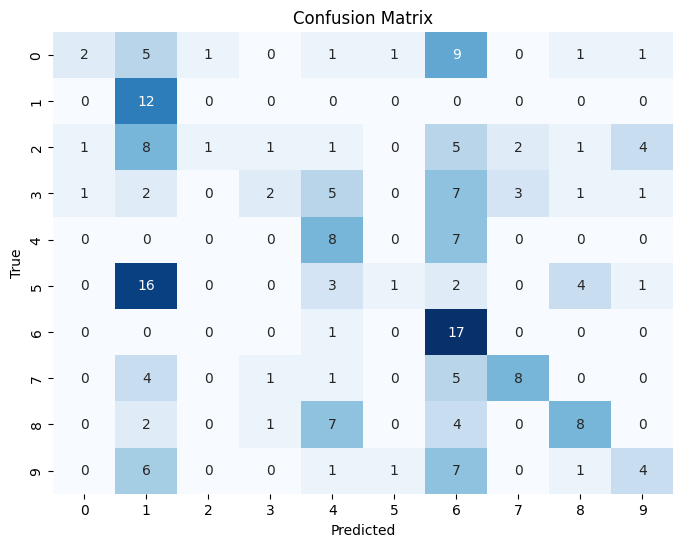

In [ ]:
# Predict the test set
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)



# Compute the confusion matrix
cm = confusion_matrix(Y_test, np.argmax(Y_pred,axis=1))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from sklearn.metrics import classification_report


# Generate classification report
report = classification_report(Y_test, np.argmax(Y_pred, axis=1))

print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.10      0.16        21
           1       0.22      1.00      0.36        12
           2       0.50      0.04      0.08        24
           3       0.40      0.09      0.15        22
           4       0.29      0.53      0.37        15
           5       0.33      0.04      0.07        27
           6       0.27      0.94      0.42        18
           7       0.62      0.42      0.50        19
           8       0.50      0.36      0.42        22
           9       0.36      0.20      0.26        20

    accuracy                           0.32       200
   macro avg       0.40      0.37      0.28       200
weighted avg       0.41      0.32      0.26       200



# Bi-LSTM 64

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import librosa
import numpy as np

model = Sequential()

# Add the first bidirectional LSTM layer
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(1, 13)))

# Add the second bidirectional LSTM layer
model.add(Bidirectional(LSTM(64)))

# Add a Dense layer with 64 neurons and ReLU activation
model.add(Dense(64, activation='relu'))

# Add a Dropout layer with a rate of 0.3
model.add(Dropout(0.3))

# Add a Dense output layer with 10 neurons and Softmax activation
model.add(Dense(10, activation='softmax'))

# Print the model summary
model.summary()

# Compile the model with the Adam optimizer and sparse categorical crossentropy loss
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history=model.fit(X_train, Y_train, epochs=30, batch_size=32, validation_split=0.2 )


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 1, 128)            39936     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 147658 (576.79 KB)
Trainable params: 147

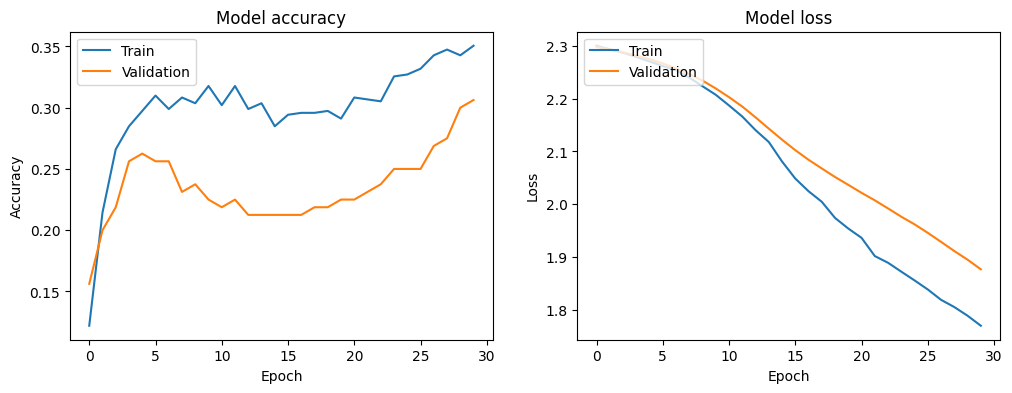

Test accuracy: 0.2850


In [ ]:
import matplotlib.pyplot as plt



# Plot the loss and accuracy
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f'Test accuracy: {test_accuracy:.4f}')


In [ ]:
loss,accuracy = model.evaluate(X_test,Y_test)
print(accuracy,loss)

7/7 [==============================] - 0s 6ms/step - loss: 1.9138 - accuracy: 0.2850
0.2849999964237213 1.9138013124465942


7/7 [==============================] - 2s 4ms/step


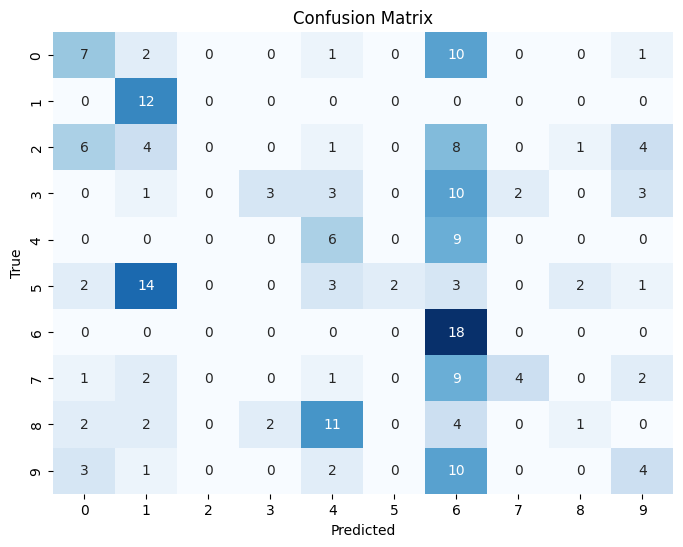

In [ ]:
# Predict the test set
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)


# Compute the confusion matrix
cm = confusion_matrix(Y_test, np.argmax(Y_pred,axis=1))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from sklearn.metrics import classification_report


# Generate classification report
report = classification_report(Y_test, np.argmax(Y_pred, axis=1))

print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.33      0.33        21
           1       0.32      1.00      0.48        12
           2       0.00      0.00      0.00        24
           3       0.60      0.14      0.22        22
           4       0.21      0.40      0.28        15
           5       1.00      0.07      0.14        27
           6       0.22      1.00      0.36        18
           7       0.67      0.21      0.32        19
           8       0.25      0.05      0.08        22
           9       0.27      0.20      0.23        20

    accuracy                           0.28       200
   macro avg       0.39      0.34      0.24       200
weighted avg       0.41      0.28      0.22       200



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Bi-LSTM 128

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Input,Bidirectional
from tensorflow.keras.optimizers import Adam

# ساخت مدل
model = Sequential()

model.add(Input(shape = (1,13)))

model.add(Bidirectional(LSTM(128)))  # None برای تعداد فریم‌ها و 13 برای ویژگی‌های MFCC


# افزودن لایه Dense با 64 نورون و تابع فعال‌ساز ReLU
model.add(Dense(64, activation='relu'))

# افزودن لایه Dropout با نرخ 0.3
model.add(Dropout(0.3))

# افزودن لایه Dense با 10 نورون خروجی و تابع فعال‌ساز Softmax
model.add(Dense(10, activation='softmax'))

# نمایش خلاصه‌ای از مدل
model.summary()

# کامپایل کردن مدل با بهینه‌ساز Adam و نرخ یادگیری 0.0001 و تابع زیان sparse_categorical_crossentropy
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


history=model.fit(X_train, Y_train, epochs=30, batch_size=32, validation_split=0.2 )


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirecti  (None, 256)               145408    
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 64)                16448     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 10)                650       
                                                                 
Total params: 162506 (634.79 KB)
Trainable params: 162506 (634.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
20/20 [==============================] - 6s 63ms/step - loss: 2.2915 

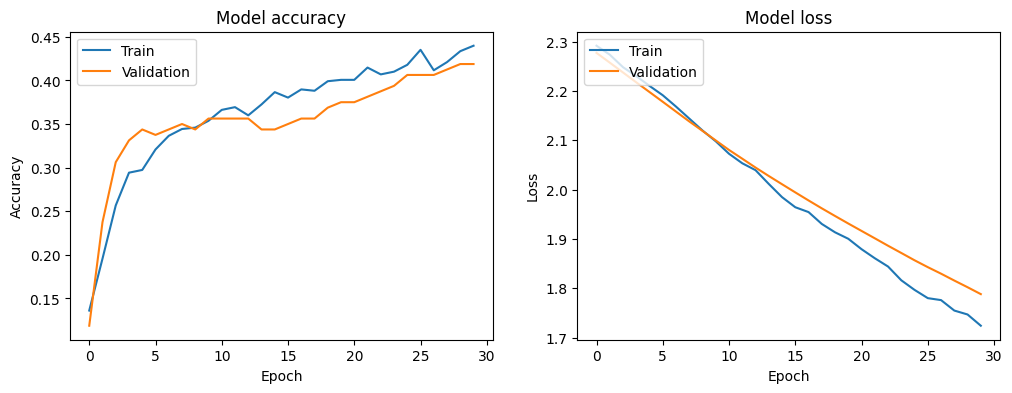

Test accuracy: 0.3650


In [ ]:
import matplotlib.pyplot as plt



# Plot the loss and accuracy
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f'Test accuracy: {test_accuracy:.4f}')


7/7 [==============================] - 1s 4ms/step


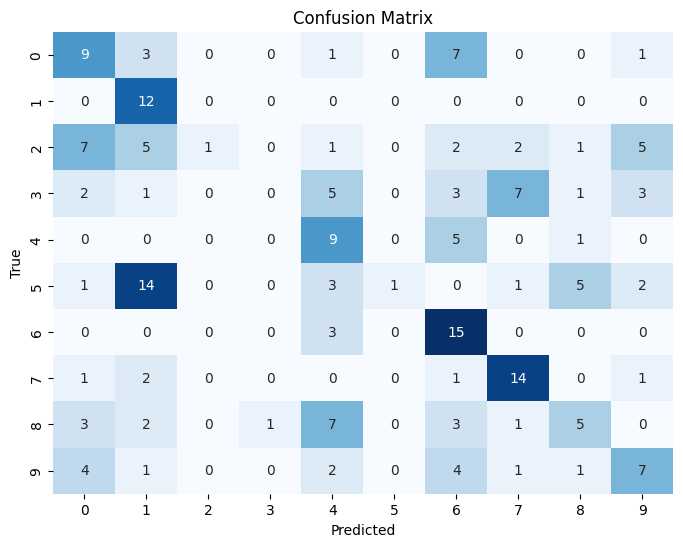

In [ ]:
# Predict the test set
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)



# Compute the confusion matrix
cm = confusion_matrix(Y_test, np.argmax(Y_pred,axis=1))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from sklearn.metrics import classification_report


# Generate classification report
report = classification_report(Y_test, np.argmax(Y_pred, axis=1))

print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.43      0.38        21
           1       0.30      1.00      0.46        12
           2       1.00      0.04      0.08        24
           3       0.00      0.00      0.00        22
           4       0.29      0.60      0.39        15
           5       1.00      0.04      0.07        27
           6       0.38      0.83      0.52        18
           7       0.54      0.74      0.62        19
           8       0.36      0.23      0.28        22
           9       0.37      0.35      0.36        20

    accuracy                           0.36       200
   macro avg       0.46      0.43      0.32       200
weighted avg       0.49      0.36      0.29       200



# Feautre extraction 2

In [ ]:
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize


# Function to extract and save spectrogram
import librosa
import numpy as np

def extract_mfcc(audio_path, sr=16000, n_mfcc=13, frame_length_ms=25, frame_stride_ms=10, max_length=160000):
    # Load the audio file
    audio, sampling_rate = librosa.load(audio_path, sr=sr)

    # Pad or truncate the audio signal to ensure it has a length of max_length samples
    audio = librosa.util.fix_length(audio, size=max_length)

    # Calculate frame length and frame stride in samples
    frame_length = int(frame_length_ms * sr / 1000)
    frame_stride = int(frame_stride_ms * sr / 1000)

    # Extract MFCC features
    mfccs = librosa.feature.mfcc(y=audio, sr=sampling_rate, n_mfcc=n_mfcc, n_fft=frame_length, hop_length=frame_stride)
    mfccs_flattened = mfccs.flatten()

    return mfccs_flattened


# Loop through the DataFrame and extract spectrograms
X=[]
Y=[]
for index, row in df.iterrows():
    file_path = row['filename']
    label = row['label']
    try:
      mfcc=extract_mfcc(file_path)
      X.append(mfcc)
      Y.append(label)
    except:
      print(f"{file_path} had problem")

<ipython-input-52-c56825cc6a4c>:14: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(audio_path, sr=sr)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


/content/Data/genres_original/jazz/jazz.00054.wav had problem


In [ ]:
# Convert to numpy arrays
X = np.array(X)
Y = np.array(Y)


In [ ]:
import numpy as np

def train_test_split1(X, y, test_size=0.25, random_state=None):

    # Convert inputs to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Ensure consistent random state
    if random_state is not None:
        np.random.seed(random_state)

    # Shuffle the indices
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    # Determine the size of the test set
    if isinstance(test_size, float):
        test_size = int(test_size * X.shape[0])
    elif isinstance(test_size, int):
        test_size = test_size
    else:
        raise ValueError("test_size should be a float or an int")

    # Split the indices for training and testing
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]

    # Split the data
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    return X_train, X_test, y_train, y_test



In [ ]:

from sklearn.model_selection import train_test_split


# Split data into training and testing sets with an 80-20 split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 799
Testing set size: 200


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape).reshape(-1, 1, X.shape[1])
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape).reshape(-1, 1, X.shape[1])



In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder


# Encode the genre labels as integers
label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(Y_train)
Y_test = label_encoder.transform(Y_test)


# LSTM 64

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# ساخت مدل
model = Sequential()


model.add(LSTM(64, input_shape=(1, X.shape[1]), return_sequences=True))  # None برای تعداد فریم‌ها و 13 برای ویژگی‌های MFCC

# افزودن لایه LSTM دوم با 64 واحد
model.add(LSTM(64))

# افزودن لایه Dense با 64 نورون و تابع فعال‌ساز ReLU
model.add(Dense(64, activation='relu'))

# افزودن لایه Dropout با نرخ 0.3
model.add(Dropout(0.3))

# افزودن لایه Dense با 10 نورون خروجی و تابع فعال‌ساز Softmax
model.add(Dense(10, activation='softmax'))

# نمایش خلاصه‌ای از مدل
model.summary()

# کامپایل کردن مدل با بهینه‌ساز Adam و نرخ یادگیری 0.0001 و تابع زیان sparse_categorical_crossentropy
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


history=model.fit(X_train, Y_train, epochs=30, batch_size=32, validation_split=0.2 )


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 1, 64)             3347968   
                                                                 
 lstm_20 (LSTM)              (None, 64)                33024     
                                                                 
 dense_24 (Dense)            (None, 64)                4160      
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 10)                650       
                                                                 
Total params: 3385802 (12.92 MB)
Trainable params: 3385802 (12.92 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
20

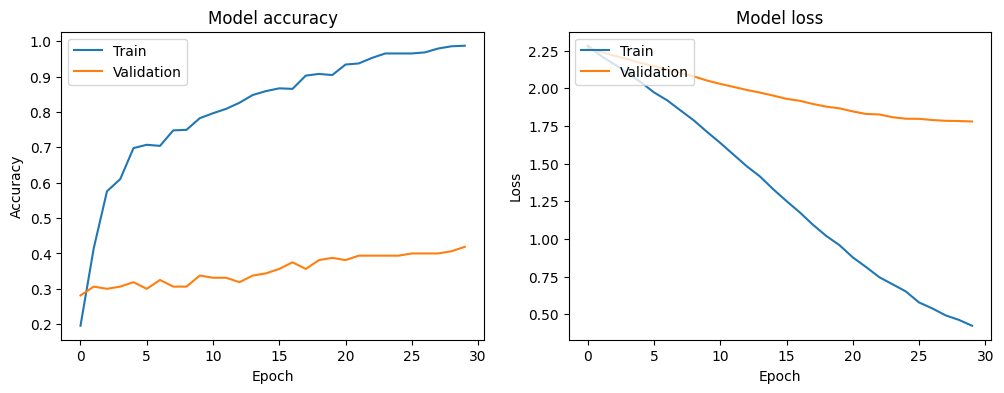

Test accuracy: 0.4000


In [ ]:
import matplotlib.pyplot as plt



# Plot the loss and accuracy
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f'Test accuracy: {test_accuracy:.4f}')


In [ ]:
model.evaluate(X_test,Y_test)

7/7 [==============================] - 0s 11ms/step - loss: 1.7724 - accuracy: 0.4000


[1.77241849899292, 0.4000000059604645]

7/7 [==============================] - 1s 11ms/step


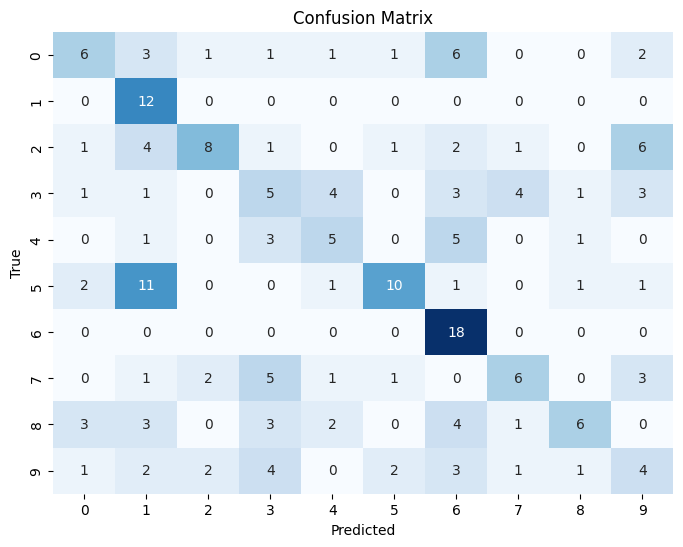

In [ ]:
# Predict the test set
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)


# Compute the confusion matrix
cm = confusion_matrix(Y_test, np.argmax(Y_pred,axis=1))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from sklearn.metrics import classification_report


# Generate classification report
report = classification_report(Y_test, np.argmax(Y_pred, axis=1))

print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.29      0.34        21
           1       0.32      1.00      0.48        12
           2       0.62      0.33      0.43        24
           3       0.23      0.23      0.23        22
           4       0.36      0.33      0.34        15
           5       0.67      0.37      0.48        27
           6       0.43      1.00      0.60        18
           7       0.46      0.32      0.37        19
           8       0.60      0.27      0.37        22
           9       0.21      0.20      0.21        20

    accuracy                           0.40       200
   macro avg       0.43      0.43      0.39       200
weighted avg       0.45      0.40      0.38       200



# LSTM 128

In [ ]:

from sklearn.model_selection import train_test_split


# Split data into training and testing sets with an 80-20 split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 799
Testing set size: 200


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape).reshape(-1, 1, X.shape[1])
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape).reshape(-1, 1, X.shape[1])



In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder


# Encode the genre labels as integers
label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(Y_train)
Y_test = label_encoder.transform(Y_test)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Input
from tensorflow.keras.optimizers import Adam

# ساخت مدل
model = Sequential()

model.add(Input(shape = (1,X.shape[1])))

model.add(LSTM(128))  # None برای تعداد فریم‌ها و 13 برای ویژگی‌های MFCC


# افزودن لایه Dense با 64 نورون و تابع فعال‌ساز ReLU
model.add(Dense(64, activation='relu'))

# افزودن لایه Dropout با نرخ 0.3
model.add(Dropout(0.3))

# افزودن لایه Dense با 10 نورون خروجی و تابع فعال‌ساز Softmax
model.add(Dense(10, activation='softmax'))

# نمایش خلاصه‌ای از مدل
model.summary()

# کامپایل کردن مدل با بهینه‌ساز Adam و نرخ یادگیری 0.0001 و تابع زیان sparse_categorical_crossentropy
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


history=model.fit(X_train, Y_train, epochs=30, batch_size=32, validation_split=0.2 )


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 128)               6728704   
                                                                 
 dense_26 (Dense)            (None, 64)                8256      
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_27 (Dense)            (None, 10)                650       
                                                                 
Total params: 6737610 (25.70 MB)
Trainable params: 6737610 (25.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
20/20 [==============================] - 8s 207ms/step - loss: 2.1817 - accuracy: 0.2269 - val_loss: 2.0414 - val_accuracy: 0.3250
Epo

In [ ]:
model.evaluate(X_test,Y_test)

7/7 [==============================] - 1s 15ms/step - loss: 1.6996 - accuracy: 0.4550


[1.6996160745620728, 0.45500001311302185]

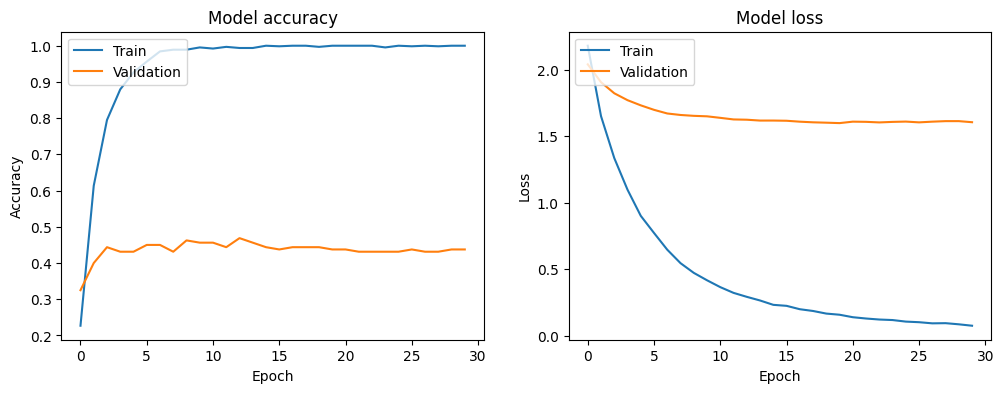

Test accuracy: 0.4550


In [ ]:
import matplotlib.pyplot as plt



# Plot the loss and accuracy
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f'Test accuracy: {test_accuracy:.4f}')


7/7 [==============================] - 1s 15ms/step


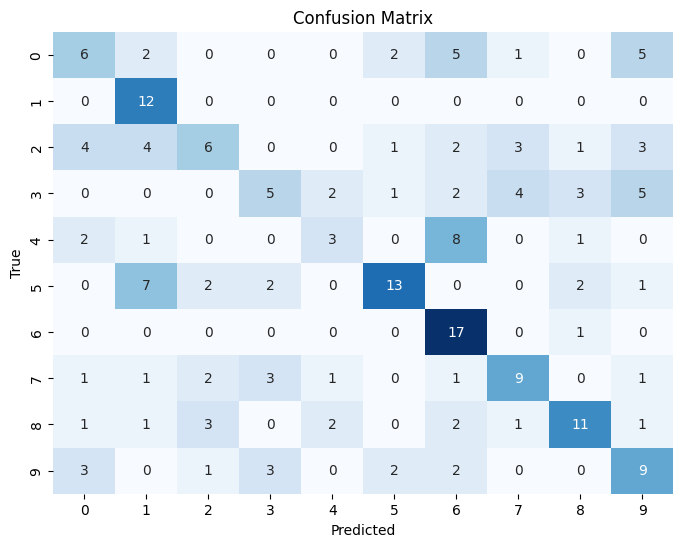

In [ ]:
# Predict the test set
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)



# Compute the confusion matrix
cm = confusion_matrix(Y_test, np.argmax(Y_pred,axis=1))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from sklearn.metrics import classification_report


# Generate classification report
report = classification_report(Y_test, np.argmax(Y_pred, axis=1))

print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.29      0.32        21
           1       0.43      1.00      0.60        12
           2       0.43      0.25      0.32        24
           3       0.38      0.23      0.29        22
           4       0.38      0.20      0.26        15
           5       0.68      0.48      0.57        27
           6       0.44      0.94      0.60        18
           7       0.50      0.47      0.49        19
           8       0.58      0.50      0.54        22
           9       0.36      0.45      0.40        20

    accuracy                           0.46       200
   macro avg       0.45      0.48      0.44       200
weighted avg       0.46      0.46      0.43       200



# Bi-LSTM 64

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import librosa
import numpy as np

model = Sequential()

# Add the first bidirectional LSTM layer
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(1, X.shape[1])))

# Add the second bidirectional LSTM layer
model.add(Bidirectional(LSTM(64)))

# Add a Dense layer with 64 neurons and ReLU activation
model.add(Dense(64, activation='relu'))

# Add a Dropout layer with a rate of 0.3
model.add(Dropout(0.3))

# Add a Dense output layer with 10 neurons and Softmax activation
model.add(Dense(10, activation='softmax'))

# Print the model summary
model.summary()

# Compile the model with the Adam optimizer and sparse categorical crossentropy loss
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history=model.fit(X_train, Y_train, epochs=30, batch_size=32, validation_split=0.2 )


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_9 (Bidirecti  (None, 1, 128)            6695936   
 onal)                                                           
                                                                 
 bidirectional_10 (Bidirect  (None, 128)               98816     
 ional)                                                          
                                                                 
 dense_28 (Dense)            (None, 64)                8256      
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_29 (Dense)            (None, 10)                650       
                                                                 
Total params: 6803658 (25.95 MB)
Trainable params: 68

In [ ]:
model.evaluate(X_test,Y_test)

7/7 [==============================] - 2s 19ms/step - loss: 1.8226 - accuracy: 0.4350


[1.8226218223571777, 0.4350000023841858]

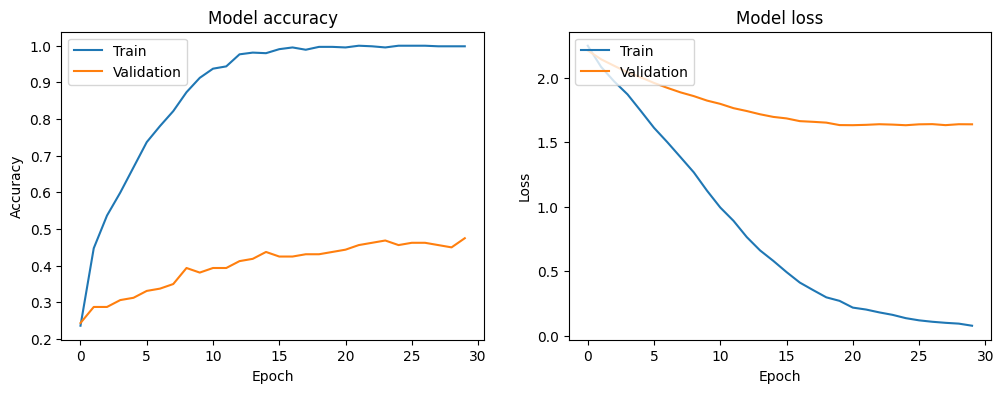

Test accuracy: 0.4350


In [ ]:
import matplotlib.pyplot as plt



# Plot the loss and accuracy
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f'Test accuracy: {test_accuracy:.4f}')


In [ ]:
loss,accuracy = model.evaluate(X_test,Y_test)
print(accuracy,loss)

7/7 [==============================] - 0s 17ms/step - loss: 1.8226 - accuracy: 0.4350
0.4350000023841858 1.8226218223571777


7/7 [==============================] - 2s 15ms/step


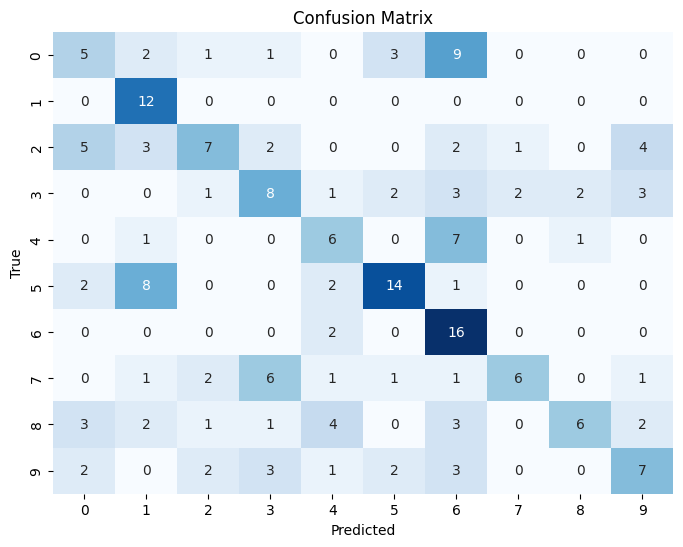

In [ ]:
# Predict the test set
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)


# Compute the confusion matrix
cm = confusion_matrix(Y_test, np.argmax(Y_pred,axis=1))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from sklearn.metrics import classification_report


# Generate classification report
report = classification_report(Y_test, np.argmax(Y_pred, axis=1))

print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.24      0.26        21
           1       0.41      1.00      0.59        12
           2       0.50      0.29      0.37        24
           3       0.38      0.36      0.37        22
           4       0.35      0.40      0.38        15
           5       0.64      0.52      0.57        27
           6       0.36      0.89      0.51        18
           7       0.67      0.32      0.43        19
           8       0.67      0.27      0.39        22
           9       0.41      0.35      0.38        20

    accuracy                           0.43       200
   macro avg       0.47      0.46      0.42       200
weighted avg       0.48      0.43      0.42       200



# Bi-LSTM 128

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Input,Bidirectional
from tensorflow.keras.optimizers import Adam

# ساخت مدل
model = Sequential()

model.add(Input(shape = (1,X.shape[1])))

model.add(Bidirectional(LSTM(128)))  # None برای تعداد فریم‌ها و 13 برای ویژگی‌های MFCC


# افزودن لایه Dense با 64 نورون و تابع فعال‌ساز ReLU
model.add(Dense(64, activation='relu'))

# افزودن لایه Dropout با نرخ 0.3
model.add(Dropout(0.3))

# افزودن لایه Dense با 10 نورون خروجی و تابع فعال‌ساز Softmax
model.add(Dense(10, activation='softmax'))

# نمایش خلاصه‌ای از مدل
model.summary()

# کامپایل کردن مدل با بهینه‌ساز Adam و نرخ یادگیری 0.0001 و تابع زیان sparse_categorical_crossentropy
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


history=model.fit(X_train, Y_train, epochs=30, batch_size=32, validation_split=0.2 )


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_11 (Bidirect  (None, 256)               13457408  
 ional)                                                          
                                                                 
 dense_30 (Dense)            (None, 64)                16448     
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_31 (Dense)            (None, 10)                650       
                                                                 
Total params: 13474506 (51.40 MB)
Trainable params: 13474506 (51.40 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
20/20 [==============================] - 10s 231ms/step - loss: 2.

In [ ]:
model.evaluate(X_test,Y_test)

7/7 [==============================] - 3s 43ms/step - loss: 1.7337 - accuracy: 0.4650


[1.7336970567703247, 0.4650000035762787]

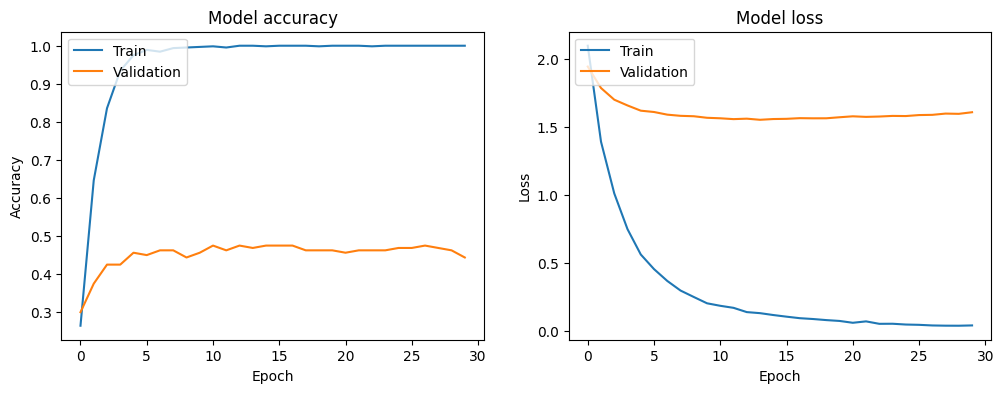

Test accuracy: 0.4650


In [ ]:
import matplotlib.pyplot as plt



# Plot the loss and accuracy
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f'Test accuracy: {test_accuracy:.4f}')


7/7 [==============================] - 2s 41ms/step


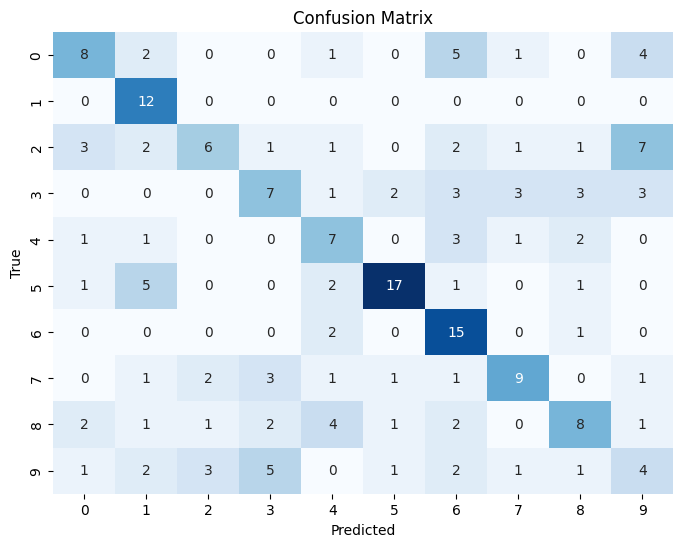

In [ ]:
# Predict the test set
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)



# Compute the confusion matrix
cm = confusion_matrix(Y_test, np.argmax(Y_pred,axis=1))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from sklearn.metrics import classification_report


# Generate classification report
report = classification_report(Y_test, np.argmax(Y_pred, axis=1))

print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.38      0.43        21
           1       0.46      1.00      0.63        12
           2       0.50      0.25      0.33        24
           3       0.39      0.32      0.35        22
           4       0.37      0.47      0.41        15
           5       0.77      0.63      0.69        27
           6       0.44      0.83      0.58        18
           7       0.56      0.47      0.51        19
           8       0.47      0.36      0.41        22
           9       0.20      0.20      0.20        20

    accuracy                           0.47       200
   macro avg       0.47      0.49      0.46       200
weighted avg       0.48      0.47      0.45       200

